In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import datetime
import pytz
import os
import patsy #for spline regression
import scipy #for non-negative least square 
import scipy as sp 
from scipy import stats
from scipy.optimize import nnls
from numpy.linalg import inv #for matrix and statistics
import scipy as sp
import math
import statsmodels.api as sm
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
import sklearn.cluster
import sklearn.linear_model
import random
%matplotlib inline

ImportError: No module named pyplot

In [87]:
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)

In [88]:
#specify data source 
datasource = 'L'

In [89]:
#zipcode = '08640'
#zipcode = '08641'
zipcode = '92562'
#zipcode = '92563'

In [90]:
#mainDir = 'C:/Users/umnouyp/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
#mainDir = 'C:/Users/Tee/Dropbox/Active/EnergyProject/Thesis/PVreadingsStudies/main'
mainDir = 'C:\Users\Admin\Dropbox\Active\EnergyProject\Thesis'
#we can choose which data to look at.
dataDir = mainDir + '/data/solar/' + datasource +'/' + zipcode +'/'
outputDir = mainDir + '/output/'+ datasource +'/' + zipcode +'/'

In [91]:
data = pd.read_csv(dataDir +'/training_data_fitted_adjusted.csv')
data['tsLocal'] = data['tsLocal'].map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

dsummary = pd.read_csv(outputDir+"/fitsummary.csv")
dsummary.Date = dsummary.Date.map(lambda x: datetime.datetime.strptime(x,"%Y-%m-%d").date())
FullModelCoef = pd.read_csv(outputDir+"/FullModelCoef.csv")

In [92]:
dsummary[:1]

,E,Rsq,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,Date,DBW,singlemax,PeakCheck,FirstCheck,SecondCheck,mE
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2013-01-01,-355,NaN,False,False,False,5.120855


In [93]:
FullModelCoef[:1]

,DBW,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10
0,0,0.177334,0.467511,0.568511,0.710033,0.746246,0.75671,0.714601,0.677578,0.527082,0.429756,0.149853


Here we define power ratio, $r$, for each power reading. We add shift to avoid infinity.

Note: In 2016, we have performed a shift to guarantee a maximum power curve. Hence, an extra shift is longer needed.

In [94]:
#shift = 0.01
#data['r'] = (data.power+shift)/(data.mpower+shift)

In [95]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r,expectedr
0,2013-01-01 07:00:00,0.772319,-298.174761,NaN,2,13.528266,-0.999883,-355,0.264652,NaN,0.706748


## Basic time series construction

Here we construct time series of power and power ratio. We add time without sun to create consistent time series. In addition, we add parallel values of previous 15 minute instances (-1, -2, ...) and previous day instances (y).

In [96]:
#specify scope
StartScopeDate = '2013-01-01'
EndScopeDate = '2015-01-01'
StartScopeTime =  datetime.datetime.strptime(StartScopeDate,"%Y-%m-%d")
EndScopeTime =  datetime.datetime.strptime(EndScopeDate,"%Y-%m-%d")

#Generate data frame from start to end for time series
tslist = []
nxt = StartScopeTime
while nxt < EndScopeTime:
    tslist.append(nxt)
    nxt += datetime.timedelta(minutes=15)
    
Scope = pd.DataFrame(0, index = np.arange(len(tslist)), columns = ['tsLocal'])
Scope['tsLocal'] = tslist

#Now we can merge using Scope Table as a backbone of data structure.
d = pd.merge(Scope,data,on=['tsLocal'], how = 'left') 

# Volatility: Definition

## Desired properties of volatility

We would like the following properties of volatilties:

1. Additive over time period: volatility of the disjoint union of time period should be equal to the sum of volatilities from each time period (up to endpoints)

2. Zero when applied to a clear day (judged by naked eye or energy production relative to maximum production)

3. Should scale when the power profile output is scaled (because we care about magnitude)

4. Should increase when the level of noise increases (we can add noise artifically)

5. Smooth low energy output should not be regarded as high volatility.

6. Preferably independent of ideal profile/ reference

7. Rolling volatility should correlate with prediction on the data on low volatility days.

## Derivative-based volatility

Hoff and Perez define volatility as a standard deviation of the change in ramp rates.

$V = SD \{ [\Delta P] \}$

It has shortcoming as the expected PV outputs is accounted as volatile. It is better to define such the change relative to a reference:

$V = SD \{ [\Delta P - \Delta P_{ref}] \}$

There are number of ways to define $ \Delta P_{ref}$. Goldstein and Thorton used monthly average. One way we can do this is to use envelope. It has shortcoming as the low PV outuputs is accounted as volatile.

Then, we may construct a set of metrics to capture volatility.

$V_0 = D[P - P_{ref}]$

$V_1 = D[P' - P'_{ref}]$ where $P'_i = P_{i+1} - P_{i}$

$V_2 = D[P'' - P''_{ref}]$ where $P''_i = P_{i+1} - 2P_{i} + P_{i-1} $

$V_3 = D[P^{(3)}]$ where $P^{(3)}_i = P_{i+2} - 3P_{i+1} + 3P_{i} - P_{i-1}$

$V_4 = D[P^{(4)}]$ where $P^{(4)}_i = P_{i+2} - 4P_{i+1} + 6P_{i} - 4P_{i-1} + P_{i-2}$

We don't need higher order because it starts to capture too long time interval. In addition, the curve is approximately splines degree 3, so the 4th order should be enough to kill all smooth variation. 


,where $P_{ref}$ can be zero, maximum envelope, or the most fitted envelope. To measure deviation, we may use absolute deviation or maximum of deviation to present more conservative number.

We may use the residual of the fit $p = c*p_{max}$ as a measure of volatility as well. This is equivalent to $V_0$ with represented to fitted envelope.

One can see easily that the properties of additivity, zero value, and independence of reference are not satisfied. In order to satisfy these properties, we need to use sum instead of deviation and assume that the higher order derivative diminishes:

$V_d = \sum[|P^{(4)}|]$ where $P^{(4)}_i = P_{i+2} - 4P_{i+1} + 6P_{i} - 4P_{i-1} + P_{i-2}$ (we don't really need reference for higher order, see below).


## Status-quo persistence volatility

Now we are going to define a new kind of volatility: status-quo persistence volatility

$V_s = \sum[|P-P_s|]$

where $P_s$ is the expected power persisted from the previous status-quo. That is, $P_s$ is the projected value of power using
$r$ from the previous time: $P_{s,i} = r_{i-1}P_{m,i}$, 

Note: If a shift is applied, we need $P_{s,i} = r_{i-1}(P_{m,i}+\text{shift})-\text{shift}$. But we don't need it as we already shift the curve to guarantee maximum.

In [97]:
data[:1]

,tsLocal,altitude,azimuth,power,numactivecomp,totalsize,s,DBW,mpower,r,expectedr
0,2013-01-01 07:00:00,0.772319,-298.174761,NaN,2,13.528266,-0.999883,-355,0.264652,NaN,0.706748


We decide that we will persue only persistence volatiltiy.

In [98]:
#select data to analyze
StartDate = datetime.date(2014,1,1)
TestData = d[d.tsLocal.map(lambda x: x.date()) >=StartDate].set_index('tsLocal')
TestDateList = list(set(TestData.index.map(lambda x: x.date())))
#set up date list and summary table
TestDateList.sort()

VariabilityTable = pd.DataFrame(float('NaN'), index = np.arange(len(TestDateList)), \
                        columns = ['V_s','V_sb'])
VariabilityTable['Date']=TestDateList

Note 'b' stands for bright hours: from 8 am to 4 pm everyday.

In [99]:
VariabilityTable[:1]

,V_s,V_sb,Date
0,NaN,NaN,2014-01-01


In [100]:
#Derivative-based volatility and status-quo volatility
for i in range(0,VariabilityTable.shape[0]):
    DailyData = TestData[TestData.index.map(lambda x: x.date()) == VariabilityTable.Date[i]]
    d_series = DailyData[['power','mpower','r']].dropna()
    d_series = d_series.reset_index(drop=True)
    
    #without shift
    l = d_series.loc[range(1,d_series.shape[0]),'power'].reset_index(drop=True)- \
            d_series.loc[range(0,d_series.shape[0]-1),'power']/d_series.loc[range(0,d_series.shape[0]-1),'mpower']* \
            d_series.loc[range(1,d_series.shape[0]),'mpower'].reset_index(drop=True)
    VariabilityTable.loc[i,'V_s'] = np.sum(np.absolute(l))
    
    #volatility for bright hours
    check = DailyData[DailyData.index.map(lambda x: (x.hour+x.minute/60.>=8)&(x.hour+x.minute/60.<=16))]
    if len(check[['power']])==len(check[['power']].dropna()):
        d_series = check[['power','mpower','r']].dropna()
        d_series = d_series.reset_index(drop=True)
       
        l = d_series.loc[range(1,d_series.shape[0]),'power'].reset_index(drop=True)- \
            d_series.loc[range(0,d_series.shape[0]-1),'power']/d_series.loc[range(0,d_series.shape[0]-1),'mpower']* \
            d_series.loc[range(1,d_series.shape[0]),'mpower'].reset_index(drop=True)
        VariabilityTable.loc[i,'V_sb'] = np.sum(np.absolute(l))
   

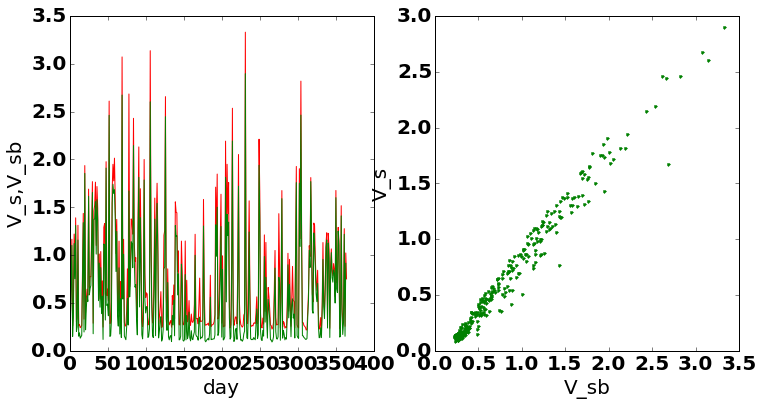

In [101]:

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
plt.plot(VariabilityTable.V_s,color='red')
plt.plot(VariabilityTable.V_sb,color='green')
plt.ylabel('V_s,V_sb')
plt.xlabel('day')
ax1 = fig.add_subplot(122)
plt.plot(VariabilityTable.V_s,VariabilityTable.V_sb,'.',color='green')
plt.ylabel('V_s')
plt.xlabel('V_sb')

In [102]:
[np.min(VariabilityTable.V_s)/np.max(VariabilityTable.V_s),
np.min(VariabilityTable.V_sb)/np.max(VariabilityTable.V_sb)]

[0.065016705439112615, 0.031781972190170517]

(array([ 145.,   39.,   35.,   20.,   22.,   23.,   20.,   15.,    9.,
          13.,    5.,    7.,    3.,    0.,    2.,    3.,    1.,    0.,
           2.,    1.]),
 array([ 0.21655656,  0.37226789,  0.52797923,  0.68369057,  0.8394019 ,
         0.99511324,  1.15082458,  1.30653592,  1.46224725,  1.61795859,
         1.77366993,  1.92938126,  2.0850926 ,  2.24080394,  2.39651528,
         2.55222661,  2.70793795,  2.86364929,  3.01936062,  3.17507196,
         3.3307833 ]),
 <a list of 20 Patch objects>)

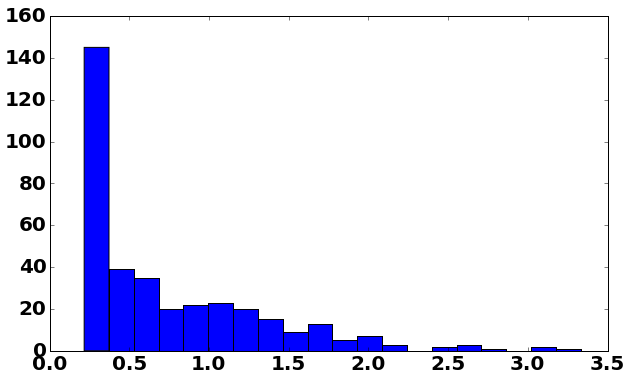

In [103]:
fig = plt.figure(figsize=(10, 6))
plt.hist(VariabilityTable.V_s,bins=20)

Let's take a closer look at days where volatlity is low. 

In [104]:
#Smooth clear days (judged by eye) for 92563

'''
l = [VariabilityTable.loc[datetime.date(2014,1,11),'V2_o'],
VariabilityTable.loc[datetime.date(2014,1,13),'V2_o'],
VariabilityTable.loc[datetime.date(2014,1,14),'V2_o'],
VariabilityTable.loc[datetime.date(2014,2,1),'V2_o'],
VariabilityTable.loc[datetime.date(2014,2,23),'V2_o'],
VariabilityTable.loc[datetime.date(2014,2,25),'V2_o'],
VariabilityTable.loc[datetime.date(2014,3,10),'V2_o'],
VariabilityTable.loc[datetime.date(2014,3,15),'V2_o'],
VariabilityTable.loc[datetime.date(2014,3,16),'V2_o'],
VariabilityTable.loc[datetime.date(2014,3,31),'V2_o']]
l
VariabilityTable[VariabilityTable.Date == datetime.date(2014,2,23)][['V2_o','V2_m','V2_c','V3','V4'
                                                                     ,'V_s','V_sh']]
'''
VariabilityTable[VariabilityTable.Date == datetime.date(2014,2,23)][['V_s','V_sb']]

,V_s,V_sb
53,0.285359,0.150345


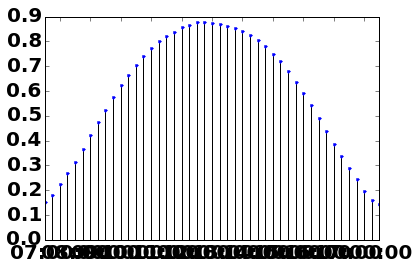

In [105]:
DailyData = TestData[TestData.index.map(lambda x: x.date()) == datetime.date(2014,2,23)]
d_series = DailyData[['power']].dropna()
#d_series = d_series.reset_index(drop=True)
plt.plot(d_series.index,d_series['power'],'.')
#d_series.plot(ylim=[0,1],style='.')
plt.vlines(x = d_series.index, ymin= 0, ymax = d_series.loc[d_series.index,'power'])

## Volatility: Location

Run all above and set VariabilityTable for different zip codes.

In [106]:
if zipcode == '08640':
    VariabilityTable_08640 = VariabilityTable
if zipcode == '08641':
    VariabilityTable_08641 = VariabilityTable
if zipcode == '92562':    
    VariabilityTable_92562 = VariabilityTable
if zipcode == '92563':
    VariabilityTable_92563 = VariabilityTable

### Nearby zipcodes

In [107]:
if ('VariabilityTable_08640' in locals()) & ('VariabilityTable_08641' in locals()):
    fig = plt.figure(figsize=(6,6))
    ax1  = fig.add_subplot(111)
    ax1.plot(VariabilityTable_08641.V_s, VariabilityTable_08640.V_s,'.')
    ax1.plot(VariabilityTable_08641.V_s, VariabilityTable_08641.V_s,color='black')
    ax1.set_xlabel('NJ data set')
    ax1.set_ylabel('neighbor NJ data set')
    ax1.set_aspect('equal')
    ax1.set_xlim(0,6)
    ax1.set_ylim(0,6)
    

In [108]:
if ('VariabilityTable_92562' in locals()) & ('VariabilityTable_92563' in locals()):
    fig = plt.figure(figsize=(6,6))
    ax1  = fig.add_subplot(111)
    ax1.plot(VariabilityTable_92562.V_s, VariabilityTable_92563.V_s,'.')
    ax1.plot(VariabilityTable_92562.V_s, VariabilityTable_92562.V_s,color='black')
    ax1.set_xlabel('CA data set')
    ax1.set_ylabel('neighbor CA data set')
    ax1.set_aspect('equal')
    ax1.set_xlim(0,4)
    ax1.set_ylim(0,4)

### CA vs. NJ

In [109]:
if ('VariabilityTable_08641' in locals()) & ('VariabilityTable_92562' in locals()):    
    fig = plt.figure(figsize=(6, 6))
    ax1 = fig.add_subplot(111)
    ax1.plot(VariabilityTable_92562.V_s, VariabilityTable_08641.V_s,'.')
    ax1.set_xlabel('CA data set')
    ax1.set_ylabel('NJ data set')
    ax1.set_aspect('equal')
    ax1.set_xlim(0,5)
    ax1.set_ylim(0,5)
    

## Volatility: Check on Toy daily power profile

Now, we compute such metrics of toy daily power profile. 

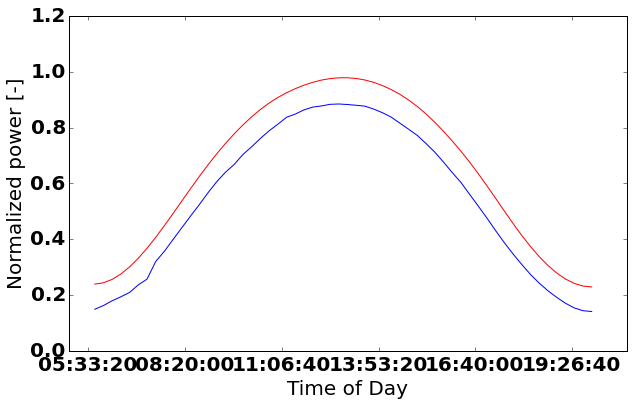

In [110]:
#For thesis, examples of maximum daily power curve
#Here we use 92562 as in Thesis chapter

DateOfInterest = "2014-06-24" #21 #24 example for good days
df = d[d.tsLocal.map(lambda x: x.date()) == (datetime.datetime.strptime(DateOfInterest,"%Y-%m-%d")).date()]

fig = plt.figure(figsize=(10,6))
ax1  = fig.add_subplot(111)

ax1.plot(df.tsLocal.map(lambda x: x.time()),df.power)
ax1.plot(df.tsLocal.map(lambda x: x.time()),df.mpower,color='red')
#ax1.plot(df.tsLocal.map(lambda x: x.time()),df.expectedr*df.mpower,color='green')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Normalized power [-]')
ax1.set_ylim([0,1.2])
ax1.set_xlim([datetime.datetime.strptime(DateOfInterest +" 05:00:00","%Y-%m-%d %H:%M:%S").time(),\
              datetime.datetime.strptime(DateOfInterest +" 21:00:00","%Y-%m-%d %H:%M:%S").time()])
#plt.title('Average normalized power in zipcode ' + zipcode +'\n' +str(DateOfInterest))
#plt.show()


#DailyData = TestData[TestData.index.map(lambda x: x.date()) == datetime.date(2014, 10, 21)]
#Do Linear regression between power and mpower 
d_series = df[['tsLocal','power','mpower']].dropna()

Here we have some basic profiles: real profile, zero profile, max power profile, max alternating profile with different alternating rate. Then we manipulate them by setting cap, scaling down, and adding noise. Note that noise introduced here is relatively low (from 0 to 20 percent). This is because we would like infer predictability when the measure of volatiity (and noise) is low. 

Except noise-added profile, we expect to see this relationship:

$0 = V(\text{zero profile}) < V(\text{max profile}) < V(\text{real profile}) < V(\text{max alternating - low rate}) < V(\text{max alternating - high rate})$ 

$ V(\text{cap}) \le V(\text{scaling down}) < V(\text{full})$ (if the total energy in cap and scaling down case are same)

$ V(\text{low noise}) \le V(\text{high noise})$

In [111]:
#define manipulated power profile

#Set O
d_series['actual'] = d_series['power']
d_series['zero'] = 0 #no power 
d_series['max'] = d_series['mpower'] #max power 

#Set I
l = [None]*d_series.shape[0]
l[::2] = [0]*len(l[::2])
l[1::2] = [1]*len(l[1::2])
d_series['oscillate'] = l
d_series['15 min'] = d_series['mpower']*d_series['oscillate'] #max alternating (15 min)
l = [None]*d_series.shape[0]
l[::4] = [0]*len(l[::4])
l[1::4] = [0]*len(l[1::4])
l[2::4] = [1]*len(l[2::4])
l[3::4] = [1]*len(l[3::4])
d_series['oscillate'] = l
d_series['30 min'] = d_series['mpower']*d_series['oscillate'] #max alternating (30 min)
l = [None]*d_series.shape[0]
l[::6] = [0]*len(l[::6])
l[1::6] = [0]*len(l[1::6])
l[2::6] = [0]*len(l[2::6])
l[3::6] = [0]*len(l[3::6])
l[4::6] = [1]*len(l[4::6])
l[5::6] = [1]*len(l[5::6])
d_series['oscillate'] = l
d_series['45 min'] = d_series['mpower']*d_series['oscillate'] #max alternating (45 min)
l = [None]*d_series.shape[0]
l[::8] = [0]*len(l[::8])
l[1::8] = [0]*len(l[1::8])
l[2::8] = [0]*len(l[2::8])
l[3::8] = [0]*len(l[3::8])
l[4::8] = [1]*len(l[4::8])
l[5::8] = [1]*len(l[5::8])
l[6::8] = [1]*len(l[6::8])
l[7::8] = [1]*len(l[7::8])
d_series['oscillate'] = l
d_series['60 min'] = d_series['mpower']*d_series['oscillate'] #max alternating (60 min)

#Set II
#vary amplitude

l = [None]*d_series.shape[0]
l[1::2] = [1]*len(l[1::2])

e = 0.2
l[::2] = [1-e]*len(l[::2])
d_series['oscillate'] = l
d_series['e = 0.2'] = d_series['mpower']*d_series['oscillate'] 
e = 0.4
l[::2] = [1-e]*len(l[::2])
d_series['oscillate'] = l
d_series['e = 0.4'] = d_series['mpower']*d_series['oscillate'] 
e = 0.6
l[::2] = [1-e]*len(l[::2])
d_series['oscillate'] = l
d_series['e = 0.6'] = d_series['mpower']*d_series['oscillate'] 
e = 0.8
l[::2] = [1-e]*len(l[::2])
d_series['oscillate'] = l
d_series['e = 0.8'] = d_series['mpower']*d_series['oscillate']

#noise generation from ideal profile
#d_series['e = 0.05'] = d_series['mpower']*(1-0.05*np.random.random_sample(len(d_series['power'])))
#d_series['e = 0.10'] = d_series['mpower']*(1-0.10*np.random.random_sample(len(d_series['power'])))
#d_series['e = 0.15'] = d_series['mpower']*(1-0.15*np.random.random_sample(len(d_series['power'])))
#d_series['e = 0.20'] = d_series['mpower']*(1-0.20*np.random.random_sample(len(d_series['power'])))

d_series = d_series.drop(['power','oscillate'], axis = 1)
d_series.set_index('tsLocal',inplace=True)


In [112]:
d_series[:1]

,mpower,actual,zero,max,15 min,30 min,45 min,60 min,e = 0.2,e = 0.4,e = 0.6,e = 0.8
tsLocal,,,,,,,,,,,,
2014-06-24 05:45:00,0.238933,0.148709,0,0.238933,0,0,0,0,0.191146,0.14336,0.095573,0.047787


(-0.1, 1.0)

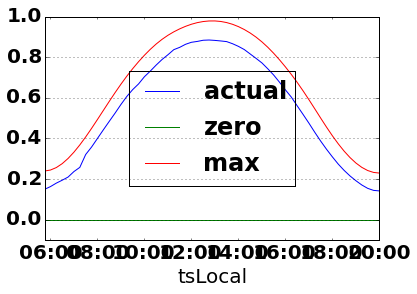

In [113]:
fig = plt.figure(figsize=(10,6))
d_series[d_series.columns[1:4]].plot()
plt.ylim(-0.1,1.0)

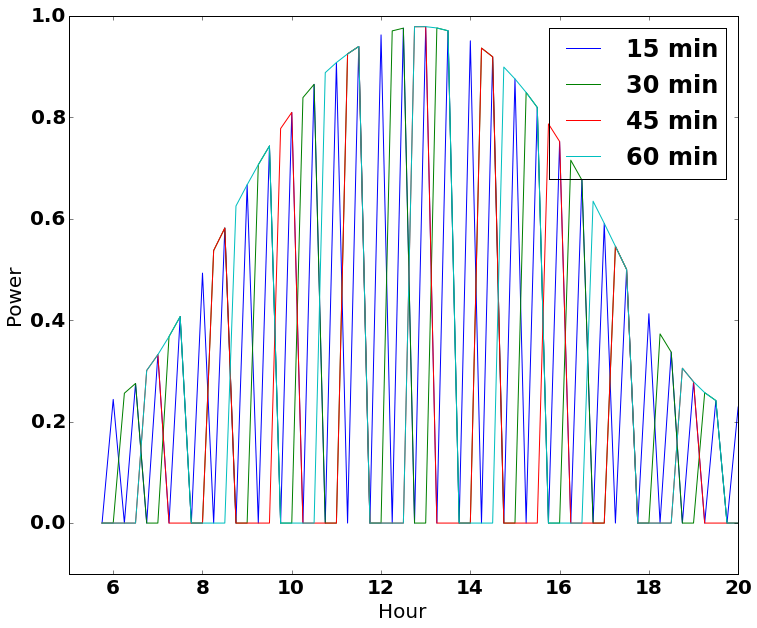

In [135]:
fig = plt.figure(figsize=(12,10))
plt.plot(d_series.index.map(lambda x: x.hour+x.minute/60.0),d_series[d_series.columns[4]],label='15 min')
plt.plot(d_series.index.map(lambda x: x.hour+x.minute/60.0),d_series[d_series.columns[5]],label='30 min')
plt.plot(d_series.index.map(lambda x: x.hour+x.minute/60.0),d_series[d_series.columns[6]],label='45 min')
plt.plot(d_series.index.map(lambda x: x.hour+x.minute/60.0),d_series[d_series.columns[7]],label='60 min')
#plt.xlim(0,70)
#plt.ylim(0,40)
plt.xlabel('Hour')
plt.ylabel('Power')
plt.ylim(-0.1,1.0)
plt.xlim(5,20)
plt.legend(loc='upper right')
#plt.locator_params(axis='x',nbins=5)

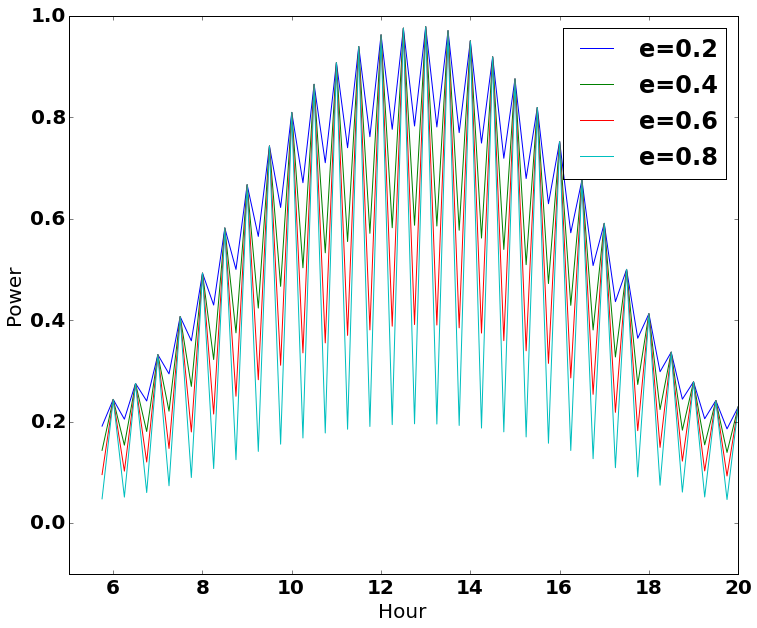

In [136]:
fig = plt.figure(figsize=(12,10))
plt.plot(d_series.index.map(lambda x: x.hour+x.minute/60.0),d_series[d_series.columns[8]],label='e=0.2')
plt.plot(d_series.index.map(lambda x: x.hour+x.minute/60.0),d_series[d_series.columns[9]],label='e=0.4')
plt.plot(d_series.index.map(lambda x: x.hour+x.minute/60.0),d_series[d_series.columns[10]],label='e=0.6')
plt.plot(d_series.index.map(lambda x: x.hour+x.minute/60.0),d_series[d_series.columns[11]],label='e=0.8')
#plt.xlim(0,70)
#plt.ylim(0,40)
plt.xlabel('Hour')
plt.ylabel('Power')
plt.ylim(-0.1,1.0)
plt.xlim(5,20)
plt.legend(loc='upper right')
#plt.locator_params(axis='x',nbins=5)


In [73]:
d_all = d_series

In [74]:
d_all.columns

Index([u'mpower', u'actual', u'zero', u'max', u'15 min', u'30 min', u'45 min', u'60 min', u'e = 0.2', u'e = 0.4', u'e = 0.6', u'e = 0.8'], dtype='object')

In [75]:
d_all.shape

(58, 12)

Set up similar table to compare volatility. We have more than 30 cases to check here.

In [76]:
VariabilityTable = pd.DataFrame(float('NaN'), index = np.arange(11), \
                        columns = ['case','V_s','V_sb'])
VariabilityTable['case']=d_all.columns[range(1,12)]

In [77]:
for i in range(0,VariabilityTable.shape[0]):
    d_series = d_all[[d_all.columns[i+1],'mpower']].dropna()
    d_series = d_series.reset_index(drop=True)
    d_series.columns = ['power','mpower']
    
    d_series = d_series.reset_index(drop=True)
    
    l = d_series.loc[range(1,d_series.shape[0]),'power'].reset_index(drop=True)- \
            d_series.loc[range(0,d_series.shape[0]-1),'power']/d_series.loc[range(0,d_series.shape[0]-1),'mpower']* \
            d_series.loc[range(1,d_series.shape[0]),'mpower'].reset_index(drop=True)
    VariabilityTable.loc[i,'V_s'] = np.sum(np.absolute(l))
    
    #volatility for bright hours
    DailyData = d_all[[d_all.columns[i+1],'mpower']].dropna()
    check = DailyData[DailyData.index.map(lambda x: (x.hour+x.minute/60.>=8)&(x.hour+x.minute/60.<=16))]
    check = check.reset_index(drop=True)
    check.columns = ['power','mpower']
    
    check = check.reset_index(drop=True)
    #check = DailyData[DailyData.index.map(lambda x: (x.hour+x.minute/60.>=8)&(x.hour+x.minute/60.<=16))]
    if len(check[['power']])==len(check[['power']].dropna()):
        d_series = check[['power','mpower']].dropna()
        d_series = d_series.reset_index(drop=True)
        l = d_series.loc[range(1,d_series.shape[0]),'power'].reset_index(drop=True)- \
            d_series.loc[range(0,d_series.shape[0]-1),'power']/d_series.loc[range(0,d_series.shape[0]-1),'mpower']* \
            d_series.loc[range(1,d_series.shape[0]),'mpower'].reset_index(drop=True)
        VariabilityTable.loc[i,'V_sb'] = np.sum(np.absolute(l))

In [78]:
# zero, max, real, max alternate low rate, ... max alternate high rate
VariabilityTable

,case,V_s,V_sb
0,actual,0.308320,0.134541
1,zero,0.000000,0.000000
2,max,0.000000,0.000000
3,15 min,37.234139,27.325789
4,30 min,18.500008,13.608049
5,45 min,12.179783,9.232435
6,60 min,9.246340,6.869170
7,e = 0.2,7.446828,5.465158
8,e = 0.4,14.893656,10.930316
9,e = 0.6,22.340483,16.395473


In [79]:
VariabilityTable.loc[3:7,'V_s']

3    37.234139
4    18.500008
5    12.179783
6     9.246340
7     7.446828
Name: V_s, dtype: float64

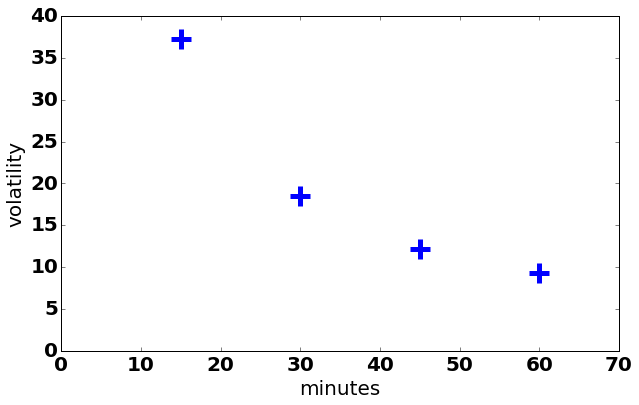

In [84]:
fig = plt.figure(figsize=(10,6))
plt.plot([15,30,45,60],VariabilityTable.loc[3:6,'V_s'],'+',markersize = 20,mew=5)
plt.xlim(0,70)
plt.ylim(0,40)
plt.xlabel('minutes')
plt.ylabel('volatility')

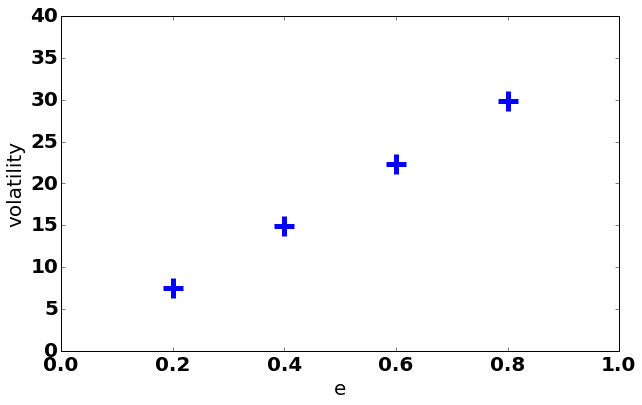

In [83]:
fig = plt.figure(figsize=(10,6))
plt.plot([0.2,0.4,0.6,0.8],VariabilityTable.loc[7:10,'V_s'],'+',markersize =20,mew=5)
plt.xlim(0,1)
plt.ylim(0,40)
plt.xlabel('e')
plt.ylabel('volatility')